# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [214]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [215]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [216]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [217]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


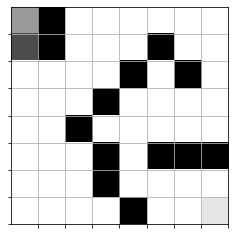

In [218]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [219]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [220]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [221]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [222]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 1500)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    n_episodes = 0

    #go through each epoch and allow the agent to make a choice and continue with the algorithm
    for epoch in range(n_epoch):
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        #if the game is not over, continue finding the path
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            #randomly choose an action to perform
            action = random.randint(0,num_actions-1)
            #carry out the action
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            episode = [previous_envstate, action, reward, envstate, game_status]
            #begin experience replay for a specific episode
            experience.remember(episode)
            #get data for the model
            X, Y = experience.get_data(data_size)
            model.fit(X, Y, batch_size=64, verbose=0)
            #loss evaluation
            loss = model.evaluate(X, Y, verbose=0)
            #decide if the agent has won or lost
            if(qmaze.game_status() == 'win'):
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                print(win_rate)
                break
            elif(qmaze.game_status() == 'lose'):
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                print(win_rate)
                break
            
    # Check win rate after each iteration and print out in the console
        if(win_rate > 0.9):
            print('Win rate above exploration threshold')
            if completion_check(model, qmaze) == True:
                print('Model Passes Completion Check')


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

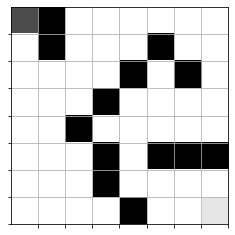

In [223]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

0.0
Epoch: 000/1499 | Loss: 0.0012 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 9.6 seconds
0.0
Epoch: 001/1499 | Loss: 0.0017 | Episodes: 280 | Win count: 0 | Win rate: 0.000 | time: 19.3 seconds
0.0
Epoch: 002/1499 | Loss: 0.0006 | Episodes: 426 | Win count: 0 | Win rate: 0.000 | time: 29.2 seconds
0.0
Epoch: 003/1499 | Loss: 0.0020 | Episodes: 570 | Win count: 0 | Win rate: 0.000 | time: 38.9 seconds
0.2
Epoch: 004/1499 | Loss: 0.0013 | Episodes: 571 | Win count: 1 | Win rate: 0.200 | time: 38.9 seconds
0.16666666666666666
Epoch: 005/1499 | Loss: 0.0022 | Episodes: 713 | Win count: 1 | Win rate: 0.167 | time: 48.6 seconds
0.14285714285714285
Epoch: 006/1499 | Loss: 0.0114 | Episodes: 856 | Win count: 1 | Win rate: 0.143 | time: 58.2 seconds
0.125
Epoch: 007/1499 | Loss: 0.0008 | Episodes: 996 | Win count: 1 | Win rate: 0.125 | time: 67.7 seconds
0.1111111111111111
Epoch: 008/1499 | Loss: 0.0008 | Episodes: 1147 | Win count: 1 | Win rate: 0.111 | time: 78.7 seconds
0.1
Ep

0.16901408450704225
Epoch: 070/1499 | Loss: 0.0016 | Episodes: 8784 | Win count: 12 | Win rate: 0.169 | time: 10.20 minutes
0.16666666666666666
Epoch: 071/1499 | Loss: 0.0013 | Episodes: 8925 | Win count: 12 | Win rate: 0.167 | time: 10.35 minutes
0.1643835616438356
Epoch: 072/1499 | Loss: 0.0010 | Episodes: 9067 | Win count: 12 | Win rate: 0.164 | time: 10.51 minutes
0.16216216216216217
Epoch: 073/1499 | Loss: 0.0003 | Episodes: 9211 | Win count: 12 | Win rate: 0.162 | time: 10.67 minutes
0.16
Epoch: 074/1499 | Loss: 0.0005 | Episodes: 9357 | Win count: 12 | Win rate: 0.160 | time: 10.83 minutes
0.15789473684210525
Epoch: 075/1499 | Loss: 0.0011 | Episodes: 9507 | Win count: 12 | Win rate: 0.158 | time: 11.00 minutes
0.16883116883116883
Epoch: 076/1499 | Loss: 0.0011 | Episodes: 9646 | Win count: 13 | Win rate: 0.169 | time: 11.16 minutes
0.16666666666666666
Epoch: 077/1499 | Loss: 0.0013 | Episodes: 9786 | Win count: 13 | Win rate: 0.167 | time: 11.32 minutes
0.16455696202531644
Epoc

0.15942028985507245
Epoch: 137/1499 | Loss: 0.0006 | Episodes: 17455 | Win count: 22 | Win rate: 0.159 | time: 19.98 minutes
0.15827338129496402
Epoch: 138/1499 | Loss: 0.0016 | Episodes: 17600 | Win count: 22 | Win rate: 0.158 | time: 20.14 minutes
0.15714285714285714
Epoch: 139/1499 | Loss: 0.0009 | Episodes: 17738 | Win count: 22 | Win rate: 0.157 | time: 20.29 minutes
0.15602836879432624
Epoch: 140/1499 | Loss: 0.0017 | Episodes: 17882 | Win count: 22 | Win rate: 0.156 | time: 20.45 minutes
0.15492957746478872
Epoch: 141/1499 | Loss: 0.0007 | Episodes: 18023 | Win count: 22 | Win rate: 0.155 | time: 20.61 minutes
0.15384615384615385
Epoch: 142/1499 | Loss: 0.0021 | Episodes: 18161 | Win count: 22 | Win rate: 0.154 | time: 20.76 minutes
0.1597222222222222
Epoch: 143/1499 | Loss: 0.0013 | Episodes: 18185 | Win count: 23 | Win rate: 0.160 | time: 20.79 minutes
0.15862068965517243
Epoch: 144/1499 | Loss: 0.0029 | Episodes: 18329 | Win count: 23 | Win rate: 0.159 | time: 20.95 minutes
0

0.1568627450980392
Epoch: 203/1499 | Loss: 0.0017 | Episodes: 25885 | Win count: 32 | Win rate: 0.157 | time: 29.51 minutes
0.16097560975609757
Epoch: 204/1499 | Loss: 0.0010 | Episodes: 25906 | Win count: 33 | Win rate: 0.161 | time: 29.54 minutes
0.1650485436893204
Epoch: 205/1499 | Loss: 0.0009 | Episodes: 25911 | Win count: 34 | Win rate: 0.165 | time: 29.54 minutes
0.16908212560386474
Epoch: 206/1499 | Loss: 0.0013 | Episodes: 25941 | Win count: 35 | Win rate: 0.169 | time: 29.58 minutes
0.16826923076923078
Epoch: 207/1499 | Loss: 0.0011 | Episodes: 26089 | Win count: 35 | Win rate: 0.168 | time: 29.75 minutes
0.1674641148325359
Epoch: 208/1499 | Loss: 0.0010 | Episodes: 26229 | Win count: 35 | Win rate: 0.167 | time: 29.91 minutes
0.16666666666666666
Epoch: 209/1499 | Loss: 0.0013 | Episodes: 26372 | Win count: 35 | Win rate: 0.167 | time: 30.07 minutes
0.16587677725118483
Epoch: 210/1499 | Loss: 0.0018 | Episodes: 26514 | Win count: 35 | Win rate: 0.166 | time: 30.23 minutes
0.1

0.17037037037037037
Epoch: 269/1499 | Loss: 0.0007 | Episodes: 34053 | Win count: 46 | Win rate: 0.170 | time: 38.82 minutes
0.16974169741697417
Epoch: 270/1499 | Loss: 0.0011 | Episodes: 34189 | Win count: 46 | Win rate: 0.170 | time: 38.98 minutes
0.16911764705882354
Epoch: 271/1499 | Loss: 0.0007 | Episodes: 34339 | Win count: 46 | Win rate: 0.169 | time: 39.14 minutes
0.17216117216117216
Epoch: 272/1499 | Loss: 0.0003 | Episodes: 34340 | Win count: 47 | Win rate: 0.172 | time: 39.15 minutes
0.17153284671532848
Epoch: 273/1499 | Loss: 0.0013 | Episodes: 34482 | Win count: 47 | Win rate: 0.172 | time: 39.30 minutes
0.1709090909090909
Epoch: 274/1499 | Loss: 0.0010 | Episodes: 34627 | Win count: 47 | Win rate: 0.171 | time: 39.47 minutes
0.17028985507246377
Epoch: 275/1499 | Loss: 0.0012 | Episodes: 34768 | Win count: 47 | Win rate: 0.170 | time: 39.63 minutes
0.16967509025270758
Epoch: 276/1499 | Loss: 0.0015 | Episodes: 34926 | Win count: 47 | Win rate: 0.170 | time: 39.81 minutes
0

0.1636904761904762
Epoch: 335/1499 | Loss: 0.0009 | Episodes: 42718 | Win count: 55 | Win rate: 0.164 | time: 48.65 minutes
0.1632047477744807
Epoch: 336/1499 | Loss: 0.0006 | Episodes: 42857 | Win count: 55 | Win rate: 0.163 | time: 48.80 minutes
0.16272189349112426
Epoch: 337/1499 | Loss: 0.0021 | Episodes: 42996 | Win count: 55 | Win rate: 0.163 | time: 48.96 minutes
0.16224188790560473
Epoch: 338/1499 | Loss: 0.0006 | Episodes: 43140 | Win count: 55 | Win rate: 0.162 | time: 49.12 minutes
0.16176470588235295
Epoch: 339/1499 | Loss: 0.0006 | Episodes: 43284 | Win count: 55 | Win rate: 0.162 | time: 49.28 minutes
0.16129032258064516
Epoch: 340/1499 | Loss: 0.0012 | Episodes: 43433 | Win count: 55 | Win rate: 0.161 | time: 49.45 minutes
0.1608187134502924
Epoch: 341/1499 | Loss: 0.0009 | Episodes: 43573 | Win count: 55 | Win rate: 0.161 | time: 49.61 minutes
0.16034985422740525
Epoch: 342/1499 | Loss: 0.0006 | Episodes: 43717 | Win count: 55 | Win rate: 0.160 | time: 49.78 minutes
0.1

0.1687344913151365
Epoch: 402/1499 | Loss: 0.0007 | Episodes: 51045 | Win count: 68 | Win rate: 0.169 | time: 58.09 minutes
0.16831683168316833
Epoch: 403/1499 | Loss: 0.0009 | Episodes: 51190 | Win count: 68 | Win rate: 0.168 | time: 58.26 minutes
0.16790123456790124
Epoch: 404/1499 | Loss: 0.0011 | Episodes: 51339 | Win count: 68 | Win rate: 0.168 | time: 58.43 minutes
0.16748768472906403
Epoch: 405/1499 | Loss: 0.0007 | Episodes: 51487 | Win count: 68 | Win rate: 0.167 | time: 58.61 minutes
0.16707616707616707
Epoch: 406/1499 | Loss: 0.0013 | Episodes: 51635 | Win count: 68 | Win rate: 0.167 | time: 58.77 minutes
0.16666666666666666
Epoch: 407/1499 | Loss: 0.0005 | Episodes: 51779 | Win count: 68 | Win rate: 0.167 | time: 58.93 minutes
0.16625916870415647
Epoch: 408/1499 | Loss: 0.0015 | Episodes: 51925 | Win count: 68 | Win rate: 0.166 | time: 59.09 minutes
0.16829268292682928
Epoch: 409/1499 | Loss: 0.0009 | Episodes: 52023 | Win count: 69 | Win rate: 0.168 | time: 59.20 minutes
0

0.17484008528784648
Epoch: 468/1499 | Loss: 0.0006 | Episodes: 59173 | Win count: 82 | Win rate: 0.175 | time: 1.12 hours
0.17446808510638298
Epoch: 469/1499 | Loss: 0.0011 | Episodes: 59317 | Win count: 82 | Win rate: 0.174 | time: 1.13 hours
0.1740976645435244
Epoch: 470/1499 | Loss: 0.0010 | Episodes: 59460 | Win count: 82 | Win rate: 0.174 | time: 1.13 hours
0.17372881355932204
Epoch: 471/1499 | Loss: 0.0011 | Episodes: 59613 | Win count: 82 | Win rate: 0.174 | time: 1.13 hours
0.1733615221987315
Epoch: 472/1499 | Loss: 0.0005 | Episodes: 59756 | Win count: 82 | Win rate: 0.173 | time: 1.14 hours
0.1729957805907173
Epoch: 473/1499 | Loss: 0.0011 | Episodes: 59896 | Win count: 82 | Win rate: 0.173 | time: 1.14 hours
0.1726315789473684
Epoch: 474/1499 | Loss: 0.0008 | Episodes: 60040 | Win count: 82 | Win rate: 0.173 | time: 1.14 hours
0.1722689075630252
Epoch: 475/1499 | Loss: 0.0015 | Episodes: 60181 | Win count: 82 | Win rate: 0.172 | time: 1.14 hours
0.1719077568134172
Epoch: 476

0.18063314711359404
Epoch: 536/1499 | Loss: 0.0013 | Episodes: 67447 | Win count: 97 | Win rate: 0.181 | time: 1.28 hours
0.18029739776951673
Epoch: 537/1499 | Loss: 0.0010 | Episodes: 67590 | Win count: 97 | Win rate: 0.180 | time: 1.28 hours
0.17996289424860853
Epoch: 538/1499 | Loss: 0.0008 | Episodes: 67730 | Win count: 97 | Win rate: 0.180 | time: 1.29 hours
0.17962962962962964
Epoch: 539/1499 | Loss: 0.0018 | Episodes: 67871 | Win count: 97 | Win rate: 0.180 | time: 1.29 hours
0.17929759704251386
Epoch: 540/1499 | Loss: 0.0011 | Episodes: 68019 | Win count: 97 | Win rate: 0.179 | time: 1.29 hours
0.17896678966789667
Epoch: 541/1499 | Loss: 0.0018 | Episodes: 68161 | Win count: 97 | Win rate: 0.179 | time: 1.30 hours
0.17863720073664824
Epoch: 542/1499 | Loss: 0.0007 | Episodes: 68307 | Win count: 97 | Win rate: 0.179 | time: 1.30 hours
0.17830882352941177
Epoch: 543/1499 | Loss: 0.0011 | Episodes: 68446 | Win count: 97 | Win rate: 0.178 | time: 1.30 hours
0.1779816513761468
Epoch

0.18016528925619835
Epoch: 604/1499 | Loss: 0.0012 | Episodes: 76211 | Win count: 109 | Win rate: 0.180 | time: 1.45 hours
0.17986798679867988
Epoch: 605/1499 | Loss: 0.0010 | Episodes: 76357 | Win count: 109 | Win rate: 0.180 | time: 1.45 hours
0.1812191103789127
Epoch: 606/1499 | Loss: 0.0010 | Episodes: 76359 | Win count: 110 | Win rate: 0.181 | time: 1.45 hours
0.18092105263157895
Epoch: 607/1499 | Loss: 0.0010 | Episodes: 76509 | Win count: 110 | Win rate: 0.181 | time: 1.45 hours
0.180623973727422
Epoch: 608/1499 | Loss: 0.0011 | Episodes: 76659 | Win count: 110 | Win rate: 0.181 | time: 1.45 hours
0.18032786885245902
Epoch: 609/1499 | Loss: 0.0012 | Episodes: 76803 | Win count: 110 | Win rate: 0.180 | time: 1.46 hours
0.18003273322422259
Epoch: 610/1499 | Loss: 0.0010 | Episodes: 76946 | Win count: 110 | Win rate: 0.180 | time: 1.46 hours
0.17973856209150327
Epoch: 611/1499 | Loss: 0.0003 | Episodes: 77092 | Win count: 110 | Win rate: 0.180 | time: 1.46 hours
0.18107667210440456

0.1812778603268945
Epoch: 672/1499 | Loss: 0.0009 | Episodes: 84598 | Win count: 122 | Win rate: 0.181 | time: 1.60 hours
0.18100890207715134
Epoch: 673/1499 | Loss: 0.0003 | Episodes: 84742 | Win count: 122 | Win rate: 0.181 | time: 1.61 hours
0.18074074074074073
Epoch: 674/1499 | Loss: 0.0009 | Episodes: 84892 | Win count: 122 | Win rate: 0.181 | time: 1.61 hours
0.1804733727810651
Epoch: 675/1499 | Loss: 0.0013 | Episodes: 85036 | Win count: 122 | Win rate: 0.180 | time: 1.61 hours
0.18168389955686853
Epoch: 676/1499 | Loss: 0.0010 | Episodes: 85075 | Win count: 123 | Win rate: 0.182 | time: 1.61 hours
0.18289085545722714
Epoch: 677/1499 | Loss: 0.0013 | Episodes: 85160 | Win count: 124 | Win rate: 0.183 | time: 1.61 hours
0.18262150220913106
Epoch: 678/1499 | Loss: 0.0015 | Episodes: 85306 | Win count: 124 | Win rate: 0.183 | time: 1.62 hours
0.18235294117647058
Epoch: 679/1499 | Loss: 0.0011 | Episodes: 85456 | Win count: 124 | Win rate: 0.182 | time: 1.62 hours
0.1820851688693098

0.18783783783783783
Epoch: 739/1499 | Loss: 0.0007 | Episodes: 92834 | Win count: 139 | Win rate: 0.188 | time: 1.76 hours
0.18758434547908232
Epoch: 740/1499 | Loss: 0.0006 | Episodes: 92979 | Win count: 139 | Win rate: 0.188 | time: 1.76 hours
0.18733153638814015
Epoch: 741/1499 | Loss: 0.0018 | Episodes: 93122 | Win count: 139 | Win rate: 0.187 | time: 1.76 hours
0.18707940780619112
Epoch: 742/1499 | Loss: 0.0006 | Episodes: 93270 | Win count: 139 | Win rate: 0.187 | time: 1.76 hours
0.1881720430107527
Epoch: 743/1499 | Loss: 0.0008 | Episodes: 93274 | Win count: 140 | Win rate: 0.188 | time: 1.77 hours
0.18926174496644296
Epoch: 744/1499 | Loss: 0.0018 | Episodes: 93290 | Win count: 141 | Win rate: 0.189 | time: 1.77 hours
0.18900804289544235
Epoch: 745/1499 | Loss: 0.0013 | Episodes: 93434 | Win count: 141 | Win rate: 0.189 | time: 1.77 hours
0.18875502008032127
Epoch: 746/1499 | Loss: 0.0013 | Episodes: 93577 | Win count: 141 | Win rate: 0.189 | time: 1.77 hours
0.188502673796791

0.18935643564356436
Epoch: 807/1499 | Loss: 0.0011 | Episodes: 101205 | Win count: 153 | Win rate: 0.189 | time: 1.92 hours
0.1903584672435105
Epoch: 808/1499 | Loss: 0.0015 | Episodes: 101210 | Win count: 154 | Win rate: 0.190 | time: 1.92 hours
0.19012345679012346
Epoch: 809/1499 | Loss: 0.0013 | Episodes: 101350 | Win count: 154 | Win rate: 0.190 | time: 1.92 hours
0.18988902589395806
Epoch: 810/1499 | Loss: 0.0005 | Episodes: 101504 | Win count: 154 | Win rate: 0.190 | time: 1.92 hours
0.1896551724137931
Epoch: 811/1499 | Loss: 0.0015 | Episodes: 101643 | Win count: 154 | Win rate: 0.190 | time: 1.92 hours
0.18942189421894218
Epoch: 812/1499 | Loss: 0.0006 | Episodes: 101786 | Win count: 154 | Win rate: 0.189 | time: 1.93 hours
0.1891891891891892
Epoch: 813/1499 | Loss: 0.0008 | Episodes: 101935 | Win count: 154 | Win rate: 0.189 | time: 1.93 hours
0.18895705521472392
Epoch: 814/1499 | Loss: 0.0011 | Episodes: 102084 | Win count: 154 | Win rate: 0.189 | time: 1.93 hours
0.188725490

0.18971428571428572
Epoch: 874/1499 | Loss: 0.0012 | Episodes: 109488 | Win count: 166 | Win rate: 0.190 | time: 2.07 hours
0.18949771689497716
Epoch: 875/1499 | Loss: 0.0011 | Episodes: 109630 | Win count: 166 | Win rate: 0.189 | time: 2.07 hours
0.18928164196123148
Epoch: 876/1499 | Loss: 0.0013 | Episodes: 109783 | Win count: 166 | Win rate: 0.189 | time: 2.08 hours
0.19020501138952164
Epoch: 877/1499 | Loss: 0.0014 | Episodes: 109800 | Win count: 167 | Win rate: 0.190 | time: 2.08 hours
0.19112627986348124
Epoch: 878/1499 | Loss: 0.0011 | Episodes: 109818 | Win count: 168 | Win rate: 0.191 | time: 2.08 hours
0.19204545454545455
Epoch: 879/1499 | Loss: 0.0008 | Episodes: 109824 | Win count: 169 | Win rate: 0.192 | time: 2.08 hours
0.19182746878547105
Epoch: 880/1499 | Loss: 0.0012 | Episodes: 109974 | Win count: 169 | Win rate: 0.192 | time: 2.08 hours
0.19160997732426305
Epoch: 881/1499 | Loss: 0.0015 | Episodes: 110120 | Win count: 169 | Win rate: 0.192 | time: 2.08 hours
0.191392

0.19745222929936307
Epoch: 941/1499 | Loss: 0.0009 | Episodes: 116867 | Win count: 186 | Win rate: 0.197 | time: 2.21 hours
0.19724284199363734
Epoch: 942/1499 | Loss: 0.0008 | Episodes: 117014 | Win count: 186 | Win rate: 0.197 | time: 2.21 hours
0.19703389830508475
Epoch: 943/1499 | Loss: 0.0008 | Episodes: 117158 | Win count: 186 | Win rate: 0.197 | time: 2.22 hours
0.19682539682539682
Epoch: 944/1499 | Loss: 0.0008 | Episodes: 117302 | Win count: 186 | Win rate: 0.197 | time: 2.22 hours
0.19661733615221988
Epoch: 945/1499 | Loss: 0.0013 | Episodes: 117456 | Win count: 186 | Win rate: 0.197 | time: 2.22 hours
0.19640971488912354
Epoch: 946/1499 | Loss: 0.0005 | Episodes: 117593 | Win count: 186 | Win rate: 0.196 | time: 2.22 hours
0.1962025316455696
Epoch: 947/1499 | Loss: 0.0006 | Episodes: 117731 | Win count: 186 | Win rate: 0.196 | time: 2.23 hours
0.19599578503688092
Epoch: 948/1499 | Loss: 0.0008 | Episodes: 117879 | Win count: 186 | Win rate: 0.196 | time: 2.23 hours
0.1957894

0.1962338949454906
Epoch: 1008/1499 | Loss: 0.0009 | Episodes: 125631 | Win count: 198 | Win rate: 0.196 | time: 2.37 hours
0.19603960396039605
Epoch: 1009/1499 | Loss: 0.0006 | Episodes: 125775 | Win count: 198 | Win rate: 0.196 | time: 2.38 hours
0.19584569732937684
Epoch: 1010/1499 | Loss: 0.0007 | Episodes: 125919 | Win count: 198 | Win rate: 0.196 | time: 2.38 hours
0.1956521739130435
Epoch: 1011/1499 | Loss: 0.0012 | Episodes: 126075 | Win count: 198 | Win rate: 0.196 | time: 2.38 hours
0.19545903257650543
Epoch: 1012/1499 | Loss: 0.0013 | Episodes: 126225 | Win count: 198 | Win rate: 0.195 | time: 2.38 hours
0.1952662721893491
Epoch: 1013/1499 | Loss: 0.0014 | Episodes: 126370 | Win count: 198 | Win rate: 0.195 | time: 2.39 hours
0.19507389162561575
Epoch: 1014/1499 | Loss: 0.0015 | Episodes: 126516 | Win count: 198 | Win rate: 0.195 | time: 2.39 hours
0.19488188976377951
Epoch: 1015/1499 | Loss: 0.0009 | Episodes: 126664 | Win count: 198 | Win rate: 0.195 | time: 2.39 hours
0.1

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.